# Video search
In this example we will be going over the code required to perform a video search. This example uses a Vgg model to extract video features that are then used with Milvus to build a system that can perform the searches. 

## Data

This example uses some gifs as an example to build an end-to-end solution that uses image to search video. Everyone can use their own video files to build the system.

Download location: https://drive.google.com/file/d/1hS4ANTQx9xNr9AByiLVeA1rEnxycdxtZ/view?usp=sharing

## Requirements

| Python Packages | Docker Servers |
| --------------- | -------------- |
| pymilvus2.0.0rc5        | Milvus 2.0-rc5   |
|

We will assume that you have familiarity with libraries including Tensorflow.

## Up and running


### 1. Start Milvus server

```bash
wget https://raw.githubusercontent.com/milvus-io/milvus/master/deployments/docker/standalone/docker-compose.yml -O docker-compose.yml
docker-compose up -d
```

This demo uses Milvus 2.0. Refer to the [Install Milvus](https://milvus.io/docs/v2.0.0/install_standalone-docker.md) for how to install Milvus docker. 

### 2. Install requirement
Install the required Python packages.

In [1]:
! pip install -r requirements.txt

## Code overview
### Connecting to server

First to connect Milvus servers. In this case the docker containers is running on localhost and the port is `19530`.

In [2]:
# Connect to Milvus
from pymilvus_orm import *
connections.connect(host="127.0.0.1", port=19520)

### Create collection and building index

The next step is to create a collection, which requires declaring the name of the collection and the dimension of the vector.

In [3]:
#Creat a collection

collection_name = "video_collection"
dim = 512
default_fields = [
    schema.FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    schema.FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=dim)
]
default_schema = schema.CollectionSchema(fields=default_fields, description="Video test collection")

collection = Collection(name=collection_name, schema=default_schema)

Create index after creating the collection. In this example we use IVF_FLAT, which takes the `nlist` parameter.

In [4]:
# Create IVF_FLAT index to the  collection
default_index = {"index_type": "IVF_FLAT", "params": {"nlist": 2048}, "metric_type": "L2"}
collection.create_index(field_name="vector", index_params=default_index)
collection.load()

### Processing the videos

In order to store the videos in Milvus, We first need to cut the frame of the video with OpenCV.

In [5]:
import cv2
import os
import shutil

video_path = "./data/3-gif"    #Path to the raw video 
save_path = "./frame_res"      # Path to save frame
if not os.path.exists(save_path):
    os.makedirs(save_path)  

filelist = os.listdir(video_path)
frame_list = []
video_list = []
for item in filelist:  
    if not item.endswith('.gif'):
        continue
    try:
        video_to_picture_path = os.path.join(save_path, item.split(".")[0])
        if not os.path.exists(video_to_picture_path):   # Create a folder corresponding to each video storage image
            os.makedirs(video_to_picture_path)
        
        src = os.path.join(video_path, item)
        vid_cap = cv2.VideoCapture(src)    
        success, image = vid_cap.read()
        count = 0
        while success:
            vid_cap.set(cv2.CAP_PROP_POS_MSEC, 1 * 1000 * count)
            frame_path = video_to_picture_path + "/" + str(count) + ".jpg"
            cv2.imwrite(frame_path, image)       # Addresses of stored images and naming of images
            frame_list.append(frame_path)
            video_list.append(item)
            success, image = vid_cap.read()
            count += 1
        print("The video:{} has:{} frames.".format(item, count))
        
    except Exception as e:
        print("There has error:", e)

print("\nThe video frame list:", frame_list)
print("\nThe video list:", video_list)       

The video:tumblr_lkwcveAjA31qdslbvo1_500.gif has:3 frames.
The video:tumblr_ll0clfX9hx1qdnpeio1_500.gif has:4 frames.
The video:tumblr_limo6fwVUq1qa8xyfo1_500.gif has:5 frames.

The video frame list: ['./frame_res/tumblr_lkwcveAjA31qdslbvo1_500/0.jpg', './frame_res/tumblr_lkwcveAjA31qdslbvo1_500/1.jpg', './frame_res/tumblr_lkwcveAjA31qdslbvo1_500/2.jpg', './frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/0.jpg', './frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/1.jpg', './frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/2.jpg', './frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/3.jpg', './frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/0.jpg', './frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/1.jpg', './frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/2.jpg', './frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/3.jpg', './frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/4.jpg']

The video list: ['tumblr_lkwcveAjA31qdslbvo1_500.gif', 'tumblr_lkwcveAjA31qdslbvo1_500.gif', 'tumblr_lkwcveAjA31qdslbvo1_500.gif', 'tumblr_ll0clfX9hx1qdnpeio1_500.gif', 'tumb

Next, we use the VGG model to extract the vectors from the images.

In [6]:
import sys
import os
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.preprocessing import image
import numpy as np
from numpy import linalg as LA

class VGGNet:
    def __init__(self):
        self.input_shape = (224, 224, 3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model_vgg = VGG16(weights=self.weight,input_shape=(self.input_shape[0], self.input_shape[1], 
                                            self.input_shape[2]), pooling=self.pooling, include_top=False)
        self.model_vgg.predict(np.zeros((1, 224, 224, 3)))

    def vgg_extract_feat(self, img_path):
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input_vgg(img)
        feat = self.model_vgg.predict(img)
        norm_feat = feat[0] / LA.norm(feat[0])
        return norm_feat.tolist()

model = VGGNet()
def feature_extract(frame_list):
    feats = []
    for img_path in frame_list:
        print("Generate the img feature vector:", img_path)
        norm_feat = model.vgg_extract_feat(img_path)
        feats.append(norm_feat)
    return feats

vectors = feature_extract(frame_list)

Generate the img feature vector: ./frame_res/tumblr_lkwcveAjA31qdslbvo1_500/0.jpg
Generate the img feature vector: ./frame_res/tumblr_lkwcveAjA31qdslbvo1_500/1.jpg
Generate the img feature vector: ./frame_res/tumblr_lkwcveAjA31qdslbvo1_500/2.jpg
Generate the img feature vector: ./frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/0.jpg
Generate the img feature vector: ./frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/1.jpg
Generate the img feature vector: ./frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/2.jpg
Generate the img feature vector: ./frame_res/tumblr_ll0clfX9hx1qdnpeio1_500/3.jpg
Generate the img feature vector: ./frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/0.jpg
Generate the img feature vector: ./frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/1.jpg
Generate the img feature vector: ./frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/2.jpg
Generate the img feature vector: ./frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/3.jpg
Generate the img feature vector: ./frame_res/tumblr_limo6fwVUq1qa8xyfo1_500/4.jpg


### Load data to Milvus
Load the vector of images into milvus and store the returned vector id along with the video name.

In [7]:
mr = collection.insert([vectors])
ids = mr.primary_keys
dicts ={}

In [8]:
assert len(ids)==len(video_list)
for i in range(len(ids)):
    dicts[ids[i]] = video_list[i]
print("The id of Milvus and video path:", dicts)

The id of Milvus and video path: {425967101326378730: 'tumblr_lkwcveAjA31qdslbvo1_500.gif', 425967101326378731: 'tumblr_lkwcveAjA31qdslbvo1_500.gif', 425967101326378732: 'tumblr_lkwcveAjA31qdslbvo1_500.gif', 425967101326378733: 'tumblr_ll0clfX9hx1qdnpeio1_500.gif', 425967101326378734: 'tumblr_ll0clfX9hx1qdnpeio1_500.gif', 425967101326378735: 'tumblr_ll0clfX9hx1qdnpeio1_500.gif', 425967101326378736: 'tumblr_ll0clfX9hx1qdnpeio1_500.gif', 425967101326378737: 'tumblr_limo6fwVUq1qa8xyfo1_500.gif', 425967101326378738: 'tumblr_limo6fwVUq1qa8xyfo1_500.gif', 425967101326378739: 'tumblr_limo6fwVUq1qa8xyfo1_500.gif', 425967101326378740: 'tumblr_limo6fwVUq1qa8xyfo1_500.gif', 425967101326378741: 'tumblr_limo6fwVUq1qa8xyfo1_500.gif'}


### Searching

When searching for an image, use the same vgg model to extract the vector of this image.

In [9]:
search_img = './data/0.jpg'

search_vector = model.vgg_extract_feat(search_img)
search_params = {"metric_type": "L2", "params": {"nprobe": 32}}
results = collection.search([search_vector], "vector", param=search_params, limit=10, expr=None)

The result of this search contains the IDs and corresponding distances of the top_k closes vectors. We can use the IDs in cache db to get the original video. 

In [10]:
def get_results(results):
    video_results = {}
    for re in results[0]:
        key = dicts[re.id]
        if not key in video_results or video_results[key]>re.distance:
            video_results[key] = re.distance
    return video_results

re = get_results(results)
print("The results:", re)

The results: {'tumblr_limo6fwVUq1qa8xyfo1_500.gif': 0.0, 'tumblr_ll0clfX9hx1qdnpeio1_500.gif': 0.7701430916786194, 'tumblr_lkwcveAjA31qdslbvo1_500.gif': 0.8358887434005737}



Show the search image:


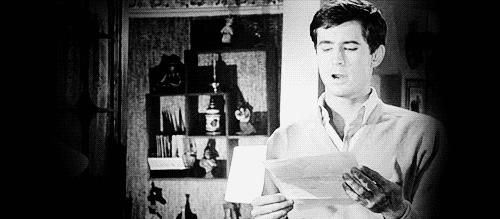


 The top:0 video, and the distance:0.0


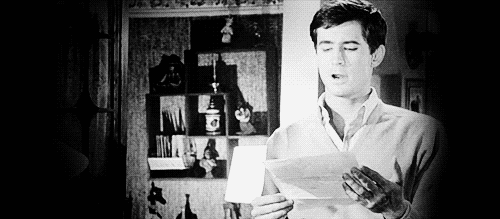


 The top:1 video, and the distance:0.7701430916786194


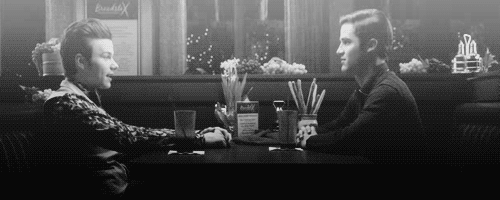


 The top:2 video, and the distance:0.8358887434005737


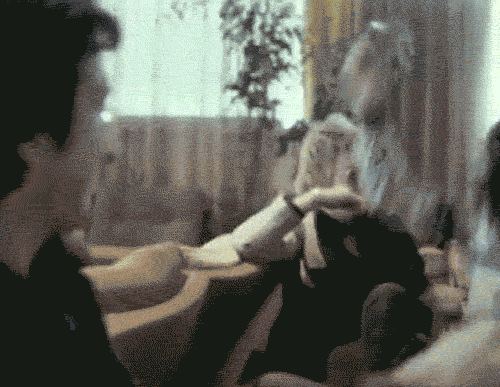

In [11]:
from IPython.display import Image
print("\nShow the search image:")
display(Image('./data/0.jpg'))
for i, key in enumerate(re):
    print("\n The top:{} video, and the distance:{}".format(i, re[key]))
    display(Image(os.path.join(video_path, key)))